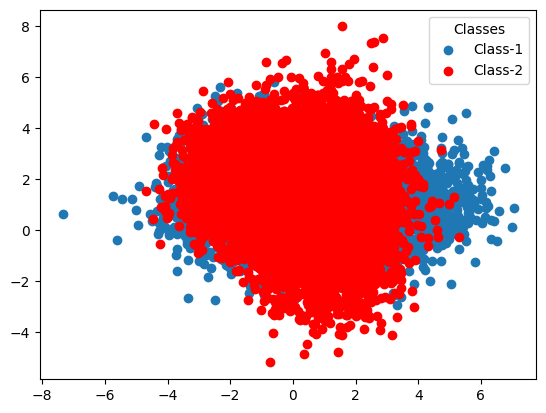

Epoch : 0
Accuracy : 0.49995
Accuracy : 0.5452
Accuracy : 0.5441
Accuracy : 0.55075
Epoch : 1
Accuracy : 0.5552
Accuracy : 0.5543


KeyboardInterrupt: 

In [4]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.metrics import roc_curve
import torch.utils.data as data_utils



# hyperparameteres: activation function, unit size, iteration size
act_func_list = ["sigmoid", "tanh", "relu"]
act_func = "sigmoid"

n_hidden_l = 5

opt_list = ["adam", "sgd"]
opt = "adam"


epoch = 500
learn_r = 0.001 # we need to tune this


# load or generate the data
c0 = loadmat('/content/drive/MyDrive/Colab Notebooks/EE423/train_binary_oct22.mat')['c0']
c1 = loadmat('/content/drive/MyDrive/Colab Notebooks/EE423/train_binary_oct22.mat')['c1']
c0 = c0 + 3*np.ones((3,1))

d = c0.shape[0] # input feature size
m = c0.shape[1] # number of observations

# Defining input size, and output size respectively
n_in, n_out = d, 1


plt.scatter(c0[0,:], c0[1,:])
plt.scatter(c1[0,:], c1[1,:], c='r')

plt.legend(("Class-1", "Class-2"), loc="upper right", title="Classes")
plt.show()

# generate input vectors
x = np.concatenate( (c0, c1), axis=1 )
x = x.astype('float')
x_t = torch.from_numpy(x.T)

y = np.concatenate( (np.zeros(shape=(1, m)), np.ones(shape=(1, m))), axis=1 )
y = y.astype('float')
y_t = torch.from_numpy(y.T)

x_t = x_t.float()
y_t = y_t.float()


train = data_utils.TensorDataset(x_t, y_t)
train_loader = data_utils.DataLoader(train, batch_size = 10, shuffle = True)


# 1 epoch : 1-pass through the whole data
# 1 iteration: 1-pass through 1 minibatch
#
# Assume we have 1000 training samples and 20 samples/minibatch
# 1 epoch is 1000/20 = 50 iterations

# define model
class CustomModel(nn.Module):
    def __init__(self, n_in, n_hidden_l, n_out):
        super(CustomModel, self).__init__()
        # Define the first linear layer
        self.linear1 = nn.Linear(n_in, n_hidden_l, bias=True)
        # Define ReLU activation
        self.relu = nn.ReLU()
        # Define dropout
        self.dropout = nn.Dropout(0.5)
        # Define the second linear layer
        self.linear2 = nn.Linear(n_hidden_l, n_out)
        # Define Sigmoid activation
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)  # First linear layer
        x = self.relu(x)     # ReLU activation
        x = self.dropout(x)  # Dropout
        x = self.linear2(x)  # Second linear layer
        x = self.sigmoid(x)  # Sigmoid activation
        return x

# Create a model
model = CustomModel(n_in, n_hidden_l, n_out)


# Construct the loss function
# binary cross entropy
criterion = nn.BCELoss()

# Construct the optimizer (Stochastic Gradient Descent in this case)

if opt == "sgd":
   # needs about 1000 epochs
   # L2 regularization is performed if weight_decay parameter is specified
   optimizer = torch.optim.SGD(model.parameters(), lr = learn_r, weight_decay=0.1)
else:
    # 100 epochs are enough
   optimizer = torch.optim.Adam(model.parameters(),lr = learn_r, betas = (0.9, 0.999))


# check this out
#train_loader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True, num_workers=1, pin_memory=True)

c0 = loadmat('/content/drive/MyDrive/Colab Notebooks/EE423/test_binary_oct22.mat')['c0']
c1 = loadmat('/content/drive/MyDrive/Colab Notebooks/EE423/test_binary_oct22.mat')['c1']
c0 = c0 + 3*np.ones((3,1))

# generate input vectors
x = np.concatenate( (c0, c1), axis=1 )
x = x.astype('float')
x_test = torch.from_numpy(x.T)
y = np.concatenate( (np.zeros(shape=(1, m)), np.ones(shape=(1, m))), axis=1 )
y = y.astype('float')
y_test = torch.from_numpy(y.T)

x_test = x_t.float()
y_test = y_t.float()



# Gradient Descent
iter=0
for epoch in range(epoch):


    print("Epoch : " + str(epoch))
    for i, (x_batch, y_batch) in enumerate(train_loader):

        # Forward pass: Compute predicted y by passing x to the model
        y_pred = model(x_batch)

           # Compute and print loss
        loss = criterion(y_pred, y_batch)


        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()

        # perform a backward pass (backpropagation)
        loss.backward()

        # Update the parameters
        optimizer.step()

        iter = iter+1

        if iter % 500 == 0:

            # convert back to the numpy format from the pytorch format
            y_pred = (model(x_t))

            # Get predictions from the maximum value
            predicted = torch.round(y_pred)

            # Total number of labels
            total = predicted.size(0)

            correct = (predicted == y_test).sum()

            print("Accuracy : " + str(correct.item()/total))
